<a href="https://colab.research.google.com/github/chinmay5/guided-research/blob/colab/Guided_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#installing all the libraries needed for the task
import pandas as pd
import json
import nltk
from pandas.io.json import json_normalize
nltk.download('stopwords')
nltk.download('punkt')
import re  
from nltk.corpus import stopwords
stops1 = set(stopwords.words("english"))
from Vocabulary import Vocab
import pickle
from torch.utils.data.sampler import Sampler
import time
import ipywidgets
import traitlets
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
processed_df = pd.read_pickle('./processed_df.pkl')

#### These are the Vocabularies that are loaded via the files

In [0]:
with open('vocab_combined.pkl','rb') as file:
    recipe_vocabulary = pickle.load(file)
    ingredient_vocabulary = pickle.load(file)

In [0]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(processed_df, test_size = 0.2, random_state = 0,
                                     stratify=processed_df.Recipe_id_numeric)

## Neural Network Part

In [0]:
# Some constants
batch_size = 1000
num_epoch = 40

In [0]:
from RecipeData import collate_fn
from RecipeData import RecipeData
import torch

In [0]:
class_sample_count_train = df_train.Recipe_id_numeric.value_counts()
class_sample_count_val = df_test.Recipe_id_numeric.value_counts()

In [0]:
# Class is imbalanced so let's handle this by weighted sampling
# weights = 1 / torch.Tensor(class_sample_count_train)
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
train_dataset = RecipeData(df_train)
train_data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           collate_fn=collate_fn,
                                           drop_last=True,
                                          #  sampler = sampler
                                           )

In [0]:
test_dataset = RecipeData(df_test)
# weights = 1 / torch.Tensor(class_sample_count_val)
# sampler = torch.utils.data.sampler.WeightedRandomSampler()
test_data_loader = torch.utils.data.DataLoader(dataset=test_dataset, # of the batch_size
                                              batch_size=batch_size,
                                              collate_fn=collate_fn,
                                              drop_last=True,
                                              # sampler=sampler
                                               )

In [12]:
df_train.Recipe_id_numeric[4]

27

In [13]:
train_dataset[0]

(tensor([557,  20,  19,  38, 142,   3,  49]), tensor(11))

In [15]:
# Moving things to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
from Networks import EmbeddingNetwork
from Networks import ClassificationNetwork

In [0]:
# These are some constants that I am just copying here
# These need to be updated based on the files
ingredient_vocabulary = 1152
recipe_vocabulary = 33
vocab_size = ingredient_vocabulary + 1
num_recipes = recipe_vocabulary + 1
hidden_dim = 128
embedding_dim = 300

In [0]:
embedding_model = EmbeddingNetwork(vocab_size=vocab_size, 
                                   hidden_dim=hidden_dim, embedding_dim=embedding_dim)

In [0]:
model = ClassificationNetwork(embedding_model=embedding_model, 
                              hidden_dim=hidden_dim,
                              num_classes=vocab_size)

### I did not put hidden state on cuda and that was an issue. So, it has been corrected

In [20]:
model.to(device)

ClassificationNetwork(
  (embedding_model): EmbeddingNetwork(
    (embedding): Embedding(1153, 300)
    (lstm): LSTM(300, 128)
  )
  (linear): Linear(in_features=128, out_features=1153, bias=True)
)

## Put loss function and categories

In [0]:
lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
def put_elements_to_device(a,b,c,device):
    return a.to(device), b.to(device), c.to(device)

In [0]:
# !pip install -q tb-nightly

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [25]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [29]:
print(len(train_data_loader) * batch_size)
print(len(train_dataset))
# Not same since we are dropping some terms which do not match up
N_train = len(train_data_loader) * batch_size
N_test = len(test_data_loader) * batch_size

79000
79948


In [0]:
save_model_name = "./lstm_model_epoch-{}"

In [31]:
for epoch in range(num_epoch):
    running_loss = 0
    correct = 0
    total = 0
    for idx,(X,X_len,y) in enumerate(train_data_loader):
        # model.train()No batch norm used yet
        model.zero_grad()
        X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
        outputs = model(X, X_len)
        loss = criterion(outputs, y)
        loss.backward(retain_graph=True)
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        running_loss =+ loss.item() * X.size(0)
        total += X.size(0)
        correct += (predicted == y).sum().item()
    print('Accuracy of the network on the train samples: %d %%' % (
        100 * correct / total))
    # writer.add_scalar('Loss/train', running_loss/N_train, epoch)
    # validation set is still left to create
    # Now to test the validation set
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for idx,(X,X_len,y) in enumerate(test_data_loader):
            X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
            outputs = model(X,X_len)
            loss = criterion(outputs, y)
            test_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += X.size(0)
            correct += (predicted == y).sum().item()
    # writer.add_scalar('Loss/test', test_loss/N_test, epoch)
    writer.add_scalars('loss_curves',
                       {'train':running_loss/len(train_dataset), 'test':test_loss/len(test_dataset)},
                       epoch)
    print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct / total))
    torch.save(model.state_dict(),save_model_name.format(epoch))    
            

Accuracy of the network on the train samples: 60 %
Accuracy of the network on the test samples: 65 %
Accuracy of the network on the train samples: 69 %
Accuracy of the network on the test samples: 71 %
Accuracy of the network on the train samples: 72 %
Accuracy of the network on the test samples: 72 %
Accuracy of the network on the train samples: 73 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 74 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 75 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 75 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 76 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 76 %
Accuracy of the network on the test samples: 73 %
Accuracy of the network on the train samples: 76 %
Accuracy of the network on the test samp

In [31]:
# !pip install tensorboard
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
# !pip uninstall tensorboard
# !pip install --force-reinstall tf-nightly-2.0-preview

##TSNE Portion

In [0]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [0]:
X_list = []
y_list = []
with torch.no_grad():
    for  idx,(X,X_len,y) in enumerate(test_data_loader):
            
            X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
            
            X_list.append(embedding_model(X, X_len)[0])
            y_list.append(y)

In [0]:
X_combined = torch.cat(X_list,0)
y_combined = torch.cat(y_list,0)

In [0]:
X = X_combined.cpu().numpy()
y = y_combined.cpu().numpy()

In [0]:
target_ids = list(range(recipe_vocabulary))# binary classification

In [38]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19000 samples in 0.109s...
[t-SNE] Computed neighbors for 19000 samples in 94.791s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19000
[t-SNE] Computed conditional probabilities for sample 2000 / 19000
[t-SNE] Computed conditional probabilities for sample 3000 / 19000
[t-SNE] Computed conditional probabilities for sample 4000 / 19000
[t-SNE] Computed conditional probabilities for sample 5000 / 19000
[t-SNE] Computed conditional probabilities for sample 6000 / 19000
[t-SNE] Computed conditional probabilities for sample 7000 / 19000
[t-SNE] Computed conditional probabilities for sample 8000 / 19000
[t-SNE] Computed conditional probabilities for sample 9000 / 19000
[t-SNE] Computed conditional probabilities for sample 10000 / 19000
[t-SNE] Computed conditional probabilities for sample 11000 / 19000
[t-SNE] Computed conditional probabilities for sample 12000 / 19000
[t-SNE] Computed conditional probabilities for s

In [0]:
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

colors = sorted_names[:9 * len(target_ids): 4]
# colors

No handles with labels found to put in legend.


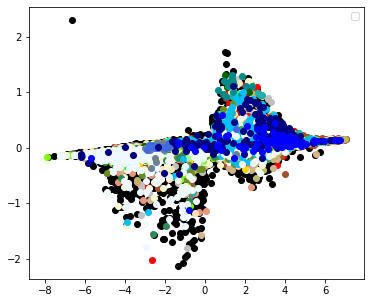

In [55]:
plt.figure(figsize=(6, 5))
for i, c in zip(target_ids, colors):
    plt.scatter(tsne_results[y == i, 0], tsne_results[y == i, 1], c=c)
plt.legend()
plt.show()

## Confusion Matrix Portion

In [0]:
correct = 0
total = 0
all_labels = []
all_predictions=[]
for idx,(X,X_len,y) in enumerate(test_data_loader):
    X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
    outputs = model(X,X_len)
    _, predicted = torch.max(outputs.data, 1)
    total += X.size(0)
    correct += (predicted == y).sum().item()
    all_labels.append(labels[idx].item())
    all_predictions.append(predicted)
print('Accuracy of the network on the test samples: %d %%' % (
        100 * correct / total))

In [0]:
from sklearn.metrics import f1_score,accuracy_score, confusion_matrix, classification_report

In [0]:
f1_score(all_labels, all_predictions, average='micro')

In [0]:
# labels = list(set(data_train.labels_encoded))
cm = confusion_matrix(all_labels, all_predictions, labels)

## The best model has been chosen and we load vectors for everything else

In [40]:
processed_df.iloc[5]

Ingredients           [orange, clove, apple, water, cinnamon]
Recipe_id                            The Spiced Cider Project
Ingredient_Numeric                       [27, 28, 29, 24, 30]
Recipe_id_numeric                                           0
Name: 5, dtype: object

In [0]:
# Recipe is entered
recipe = "The Spiced Cider Project" # to be obtained as input later
recipe_id = processed_df.Recipe_id.get(recipe)

# Just checking stuff here :(


#### One can take 1000 samples here and simply stack them on top of each other, then pass through the network

In [42]:
# Ingredient_Numeric
ingreds = processed_df.iloc[5].Ingredient_Numeric
ingreds = (torch.as_tensor(ingreds)).unsqueeze(0)
embeddings = model.embedding(torch.as_tensor(ingreds).cuda()) #tensor needed
#embeddings.shape
# Let us pass this through the LSTM :)
output, _ = model.lstm(embeddings)
output.squeeze_(0)
output.shape

AttributeError: ignored

In [0]:
class IngredientEmbedding(object):

  def __init__(self):
    super(IngredientEmbedding, self).__init__()
    self.ingredient_embedding = dict() # A list for all ingredients
    
  def add_constituents(self, ingred_list, embedding):
    for idx, ingred  in enumerate(ingred_list):
        self.ingredient_embedding[ingred] = embedding[idx]

  def __repr__(self):
    return str(self.ingredient_embedding.keys())
    
  def get_embeddings(self):
    x = [ value for (key, value) in self.ingredient_embedding.items()]
    return x

In [0]:
ingreds = processed_df.iloc[5].Ingredient_Numeric
ingredient_embedding = IngredientEmbedding()
ingredient_embedding.add_constituents(ingreds, output)
ingredient_embedding

In [0]:
ingredient_embedding.get_embeddings()

In [0]:
# Now I want to put things into the Recipe object
class Recipe(object):

  def __init__(self):
    super(Recipe,self).__init__()
    self.ingred_embedding = IngredientEmbedding()

  def create(self, id, name, ingred, numeric, embeddings):
    self.common_id = id
    self.name = name
    self.IngredientNumeric = numeric
    self.Ingredients = ingred
    self.ingred_embedding = embeddings
  
  def get_repr(self):
    return (self.common_id, self.Ingredients)

  def get_embeddings(self):
    return self.ingred_embedding.get_embeddings()

In [0]:
sample_element = processed_df.iloc[5]

In [0]:
my_recipe = Recipe()
my_recipe.create(id=sample_element.Recipe_id_numeric,
                 name=sample_element.Recipe_id,
                 ingred=sample_element.Ingredients,
                 numeric=sample_element.Ingredients,
                 embeddings=ingredient_embedding
                 )

## tSNE visualisation

In [0]:
embedder = model.get_embedder()

In [0]:
# Let us work with only the Non-zero column to see if there is any learning at all
df_temp = processed_df[processed_df.Recipe_id_numeric > 0]
df_temp.groupby('Recipe_id_numeric').count()

In [0]:
# This is a hacky solution
# I am passing all elements in a single batch
# so that they can be stacked
# num_samples = batch_size = 1000
train_dataset_tsne = RecipeData(df_temp)
sampler = torch.utils.data.RandomSampler(train_dataset_tsne, replacement=True, num_samples=1000)
train_data_loader_tsne = torch.utils.data.DataLoader(dataset=train_dataset_tsne,
                                              batch_size=1000,
                                              collate_fn=collate_fn,
                                               drop_last=True,
                                               sampler = sampler
                                               ) # Done for cases when num_samples not exact multiple

In [0]:
X_tsne = []
y_tsne = []
with torch.no_grad():
    for idx,(X,X_len,y) in enumerate(train_data_loader_tsne):
            X, X_len, y = put_elements_to_device(a=X, b=torch.tensor(X_len), c=y, device=device)
            h_n, seq_embed = embedder(X, X_len)
            flatten_seq_embed = seq_embed.reshape(seq_embed.size(0), -1)
            X_tsne.append(flatten_seq_embed)
            y_tsne.append(y)

In [0]:
X_combined = torch.cat(X_tsne,0)
y_combined = torch.cat(y_tsne,0)

In [0]:
X = X_combined.cpu().numpy()
y = y_combined.cpu().numpy()

In [0]:
target_ids = class_vector.numpy() # binary classification
target_ids = target_ids.tolist()

In [0]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [0]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

In [0]:
colors = sorted_names[:9 * len(class_vector): 14]
colors

In [0]:
plt.figure(figsize=(6, 5))
for i, c in zip(target_ids, colors):
    plt.scatter(tsne_results[y == i, 0], tsne_results[y == i, 1], c=c)
plt.legend()
plt.show()